# Metabolomica LC–MS: feature table, QC, normalizzazione e analisi

Obiettivi del notebook:
- Simulare un piccolo dataset di **metabolomica LC–MS untargeted** (feature m/z–RT × campioni).
- Eseguire passi base di **QC** (TIC, distribuzioni di intensità).
- Applicare una **normalizzazione** semplice.
- Eseguire una **PCA** e una **analisi differenziale** (t-test + volcano plot).

_Tutti i dati sono simulati per fini didattici, ispirati a un tipico peak table LC–MS._

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline
np.random.seed(2025)

## 1. Simulazione di una tabella di feature LC–MS

Impostiamo:
- 250 feature (picchi) descritte da m/z, RT (minuti) e intensità.
- 10 campioni: 5 controlli (CTRL) e 5 esposti (EXP) – ad es. organismi in acqua pulita vs inquinata.
- La maggior parte delle feature non mostra differenze sistematiche.
- Un piccolo set di feature "biomarker" mostra intensità maggiori nel gruppo esposto.


In [2]:
n_features = 250
n_ctrl = 5
n_exp = 5
n_samples = n_ctrl + n_exp

sample_ids = [f"CTRL_{i+1}" for i in range(n_ctrl)] + [f"EXP_{i+1}" for i in range(n_exp)]
conditions = pd.Series([
    "CTRL" for _ in range(n_ctrl)
] + [
    "EXP" for _ in range(n_exp)
], index=sample_ids, name="condition")

# m/z e RT fittizi
mz_values = np.random.uniform(80, 1000, size=n_features)
rt_values = np.random.uniform(0.5, 20.0, size=n_features)  # minuti

feature_ids = [f"FT_{i+1:04d}" for i in range(n_features)]

# Intensità base log10 ~ N(5, 0.5)
log10_intens_base = np.random.normal(loc=5.0, scale=0.5, size=(n_features, n_samples))
intensities = 10 ** log10_intens_base

# Selezioniamo 15 feature come "differenziali" (più alte negli esposti)
n_de = 15
de_idx = np.random.choice(np.arange(n_features), size=n_de, replace=False)
for idx in de_idx:
    # aumento di ~0.6 log10 (≈ x4 in intensità) nel gruppo EXP
    intensities[idx, conditions.values == "EXP"] *= (10 ** 0.6)

# Aggiungiamo un po' di missing values (es. feature a bassa intensità)
scaled_mean = intensities.mean(axis=1) / intensities.mean()
prob_missing = np.interp(scaled_mean, (scaled_mean.min(), scaled_mean.max()), (0.4, 0.02))
mask_missing = np.zeros_like(intensities, dtype=bool)
for i in range(n_features):
    for j in range(n_samples):
        if np.random.rand() < prob_missing[i]:
            mask_missing[i, j] = True
intensities_masked = intensities.copy()
intensities_masked[mask_missing] = np.nan

intensity_cols = [f"INT_{sid}" for sid in sample_ids]
data = pd.DataFrame(intensities_masked, columns=intensity_cols)
data.insert(0, "RT_min", rt_values)
data.insert(0, "mz", mz_values)
data.insert(0, "FeatureID", feature_ids)
data.head()

,FeatureID,mz,RT_min,INT_CTRL_1,INT_CTRL_2,INT_CTRL_3,INT_CTRL_4,INT_CTRL_5,INT_EXP_1,INT_EXP_2,INT_EXP_3,INT_EXP_4,INT_EXP_5
0,FT_0001,204.649111,4.741469,44510.768094,259040.349119,6484.596615,NaN,33844.199357,NaN,370515.955147,74730.177856,55986.438423,3.648329e+05
1,FT_0002,896.823567,2.649855,163051.500176,98122.229477,364351.242177,NaN,49344.882765,NaN,147274.438371,NaN,29497.081378,8.744174e+04
2,FT_0003,937.997189,19.106768,135904.699322,71005.052755,52659.383953,NaN,NaN,NaN,186510.412922,89873.706945,163083.542149,1.026225e+05
3,FT_0004,489.922711,17.417574,228631.823539,81872.268195,198765.806406,112566.589771,237879.833941,23024.495868,66426.617061,905016.017682,747003.309737,1.991403e+06
4,FT_0005,437.176702,6.752384,NaN,73247.989454,273786.506944,NaN,334212.024076,NaN,NaN,14840.047698,NaN,7.860858e+05


## 2. QC: Total Ion Current (TIC) per campione

Calcoliamo per ciascun campione la somma delle intensità (TIC) come misura grossolana di carico totale.

In [3]:
tic = data[intensity_cols].sum(axis=0, skipna=True)
tic

INT_CTRL_1    3.157795e+07
INT_CTRL_2    4.724797e+07
INT_CTRL_3    3.494300e+07
INT_CTRL_4    2.927198e+07
INT_CTRL_5    3.483572e+07
INT_EXP_1     4.677603e+07
INT_EXP_2     3.847004e+07
INT_EXP_3     4.715169e+07
INT_EXP_4     4.077570e+07
INT_EXP_5     4.397544e+07
dtype: float64

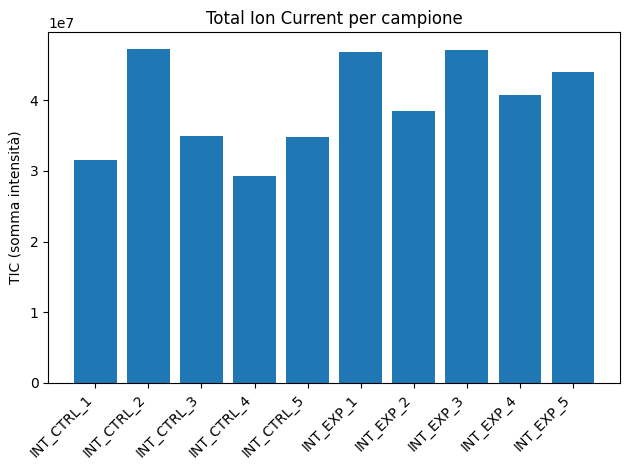

In [4]:
plt.bar(range(len(intensity_cols)), tic.values)
plt.xticks(range(len(intensity_cols)), intensity_cols, rotation=45, ha="right")
plt.ylabel("TIC (somma intensità)")
plt.title("Total Ion Current per campione")
plt.tight_layout()
plt.show()

## 3. Distribuzioni di intensità (log10) per campione

Convertiamo le intensità in log10 e confrontiamo le distribuzioni tra campioni.

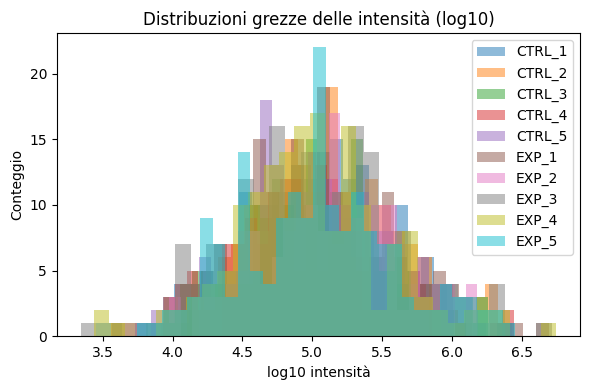

In [5]:
log10_data = np.log10(data[intensity_cols])
plt.figure(figsize=(6,4))
for sid in sample_ids:
    col = f"INT_{sid}"
    plt.hist(log10_data[col].dropna(), bins=30, alpha=0.5, label=sid)
plt.xlabel("log10 intensità")
plt.ylabel("Conteggio")
plt.title("Distribuzioni grezze delle intensità (log10)")
plt.legend()
plt.tight_layout()
plt.show()

In dataset reali, differenze globali tra campioni richiedono **normalizzazione**.

## 4. Normalizzazione per TIC

Applichiamo una normalizzazione semplice: dividiamo le intensità di ciascun campione per il suo TIC e riportiamo in log10.


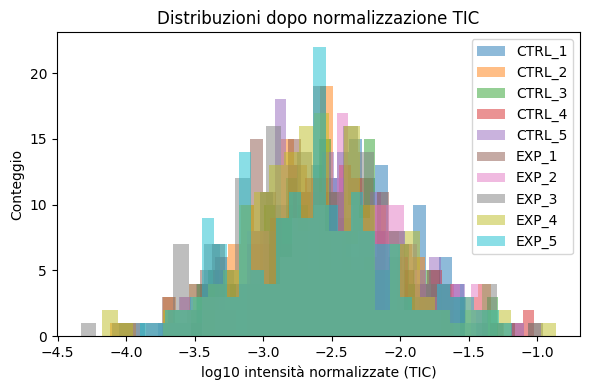

In [6]:
norm_intens = data[intensity_cols].copy()
for col in intensity_cols:
    norm_intens[col] = norm_intens[col] / tic[col]

norm_log10 = np.log10(norm_intens)
plt.figure(figsize=(6,4))
for sid in sample_ids:
    col = f"INT_{sid}"
    plt.hist(norm_log10[col].dropna(), bins=30, alpha=0.5, label=sid)
plt.xlabel("log10 intensità normalizzate (TIC)")
plt.ylabel("Conteggio")
plt.title("Distribuzioni dopo normalizzazione TIC")
plt.legend()
plt.tight_layout()
plt.show()

Aggiorniamo il nostro DataFrame con le intensità normalizzate (log10).

In [7]:
norm_data = data.copy()
for col in intensity_cols:
    norm_data[col] = norm_log10[col]
norm_data.head()

,FeatureID,mz,RT_min,INT_CTRL_1,INT_CTRL_2,INT_CTRL_3,INT_CTRL_4,INT_CTRL_5,INT_EXP_1,INT_EXP_2,INT_EXP_3,INT_EXP_4,INT_EXP_5
0,FT_0001,204.649111,4.741469,-2.850919,-2.261016,-3.731477,NaN,-3.012541,NaN,-2.016316,-2.800001,-2.862319,-2.081116
1,FT_0002,896.823567,2.649855,-2.287059,-2.682616,-1.981840,NaN,-2.848783,NaN,-2.416995,NaN,-3.140622,-2.701491
2,FT_0003,937.997189,19.106768,-2.366149,-2.823094,-2.821884,NaN,NaN,NaN,-2.314420,-2.719865,-2.397991,-2.631968
3,FT_0004,489.922711,17.417574,-2.140247,-2.761246,-2.245019,-2.415043,-2.165667,-3.307833,-2.762781,-1.716841,-1.737079,-1.344051
4,FT_0005,437.176702,6.752384,NaN,-2.809587,-2.105948,NaN,-2.018003,NaN,NaN,-3.502062,NaN,-1.747740


## 5. Filtraggio di feature con troppi missing

Per un'analisi statistica semplice, richiediamo che una feature sia presente in
- almeno 4/5 campioni in ciascun gruppo (CTRL ed EXP).

In [8]:
ctrl_cols = [f"INT_CTRL_{i+1}" for i in range(n_ctrl)]
exp_cols = [f"INT_EXP_{i+1}" for i in range(n_exp)]

mask_ctrl = norm_data[ctrl_cols].notna().sum(axis=1) >= 4
mask_exp = norm_data[exp_cols].notna().sum(axis=1) >= 4
keep = mask_ctrl & mask_exp
filtered = norm_data.loc[keep].reset_index(drop=True)
print(f"Feature totali: {len(norm_data)}")
print(f"Feature dopo filtro missing: {len(filtered)}")

Feature totali: 250
Feature dopo filtro missing: 60


## 6. PCA sui campioni

Applichiamo una PCA "fatta a mano" (via SVD) sulle intensità normalizzate, per vedere se i campioni CTRL ed EXP si separano.

1. Usiamo solo le feature filtrate.
2. Centriamo per feature (sottraiamo la media).
3. Calcoliamo la SVD e prendiamo le prime due componenti principali.

In [9]:
# Matrice feature × campioni (usiamo .T per avere campioni × feature)
X = filtered[intensity_cols].values  # righe = feature, colonne = campioni
X = X.T  # righe = campioni, colonne = feature

# Sostituiamo eventuali NaN con la media della feature (colonna)
col_means = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_means, inds[1])

# Centriamo per colonna (feature)
X_centered = X - X.mean(axis=0, keepdims=True)

# SVD
U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
PCs = U[:, :2] * S[:2]  # punteggi delle prime due PC

pca_df = pd.DataFrame(
    PCs,
    columns=["PC1", "PC2"],
    index=sample_ids,
)
pca_df

,PC1,PC2
CTRL_1,-0.060956,-1.422630
CTRL_2,1.229585,0.885765
CTRL_3,-0.271609,-0.672496
CTRL_4,1.939892,-2.273970
CTRL_5,1.028064,-0.683999
EXP_1,1.792779,1.307286
EXP_2,-0.171034,-0.702398
EXP_3,-4.446086,-1.203064
EXP_4,-1.631894,3.092199
EXP_5,0.591260,1.673308


### Plot PCA (PC1 vs PC2)

I campioni dovrebbero mostrarsi in qualche modo separati tra CTRL ed EXP se le feature differenziali sono abbastanza marcate.

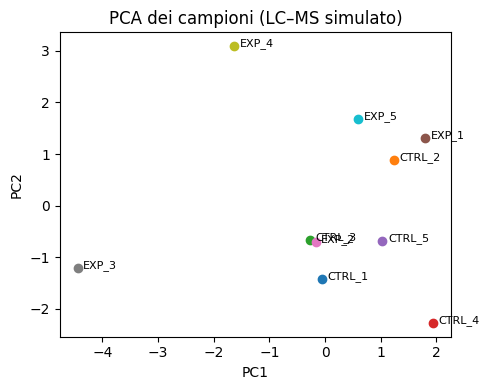

In [10]:
plt.figure(figsize=(5,4))
for sid in sample_ids:
    cond = conditions[sid]
    x = pca_df.loc[sid, "PC1"]
    y = pca_df.loc[sid, "PC2"]
    plt.scatter(x, y)
    plt.text(x+0.1, y, sid, fontsize=8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA dei campioni (LC–MS simulato)")
plt.tight_layout()
plt.show()

## 7. Analisi differenziale feature per feature

Per ogni feature filtrata:
- calcoliamo la media nei due gruppi.
- log2 fold change = EXP − CTRL (usando le intensità log10 normalizzate, convertite a log2 per la leggibilità).
- eseguiamo un t-test (CTRL vs EXP).

_Nota_: lavoriamo su log10, ma convertiamo la differenza a scala log2 per interpretare facilmente le fold-change._

In [12]:
# converto le colonne dei campioni a numerico (non convertibili -> NaN)
filtered[ctrl_cols] = filtered[ctrl_cols].apply(pd.to_numeric, errors="coerce")
filtered[exp_cols]  = filtered[exp_cols].apply(pd.to_numeric, errors="coerce")

results = []
log2_factor = np.log2(10)

for idx, row in filtered.iterrows():
    vals_ctrl = row[ctrl_cols].values.astype(float)
    vals_exp  = row[exp_cols].values.astype(float)

    mean_ctrl = np.nanmean(vals_ctrl)
    mean_exp  = np.nanmean(vals_exp)

    diff_log10 = mean_exp - mean_ctrl
    log2_fc = diff_log10 * log2_factor

    # se vuoi evitare test con troppi NaN, puoi filtrare:
    clean_ctrl = vals_ctrl[~np.isnan(vals_ctrl)]
    clean_exp  = vals_exp[~np.isnan(vals_exp)]

    if len(clean_ctrl) > 1 and len(clean_exp) > 1:
        tstat, pval = stats.ttest_ind(clean_exp, clean_ctrl,
                                      equal_var=False, nan_policy="omit")
    else:
        pval = np.nan  # oppure qualche valore di default

    results.append({
        "FeatureID": row["FeatureID"],
        "mz": row["mz"],
        "RT_min": row["RT_min"],
        "mean_CTRL_log10": mean_ctrl,
        "mean_EXP_log10": mean_exp,
        "log2_FC_EXP_vs_CTRL": log2_fc,
        "pval": pval,
    })

res_df = pd.DataFrame(results)
res_df.head()


,FeatureID,mz,RT_min,mean_CTRL_log10,mean_EXP_log10,log2_FC_EXP_vs_CTRL,pval
0,FT_0001,204.649111,4.741469,-2.963988,-2.439938,1.740857,0.218658
1,FT_0004,489.922711,17.417574,-2.345444,-2.173717,0.570466,0.676045
2,FT_0006,316.988720,17.886489,-2.831167,-2.457008,1.242927,0.521558
3,FT_0007,684.778179,4.465225,-2.614734,-1.790994,2.736406,0.010276
4,FT_0008,533.207583,11.402809,-2.723148,-2.678850,0.147154,0.880861


Aggiungiamo −log₁₀(p-value) e costruiamo un volcano plot.

In [13]:
res_df["neg_log10_pval"] = -np.log10(res_df["pval"])
res_df.head()

,FeatureID,mz,RT_min,mean_CTRL_log10,mean_EXP_log10,log2_FC_EXP_vs_CTRL,pval,neg_log10_pval
0,FT_0001,204.649111,4.741469,-2.963988,-2.439938,1.740857,0.218658,0.660235
1,FT_0004,489.922711,17.417574,-2.345444,-2.173717,0.570466,0.676045,0.170024
2,FT_0006,316.988720,17.886489,-2.831167,-2.457008,1.242927,0.521558,0.282697
3,FT_0007,684.778179,4.465225,-2.614734,-1.790994,2.736406,0.010276,1.988177
4,FT_0008,533.207583,11.402809,-2.723148,-2.678850,0.147154,0.880861,0.055093


## 8. Volcano plot

Plot:
- asse X: log₂ FC
- asse Y: −log₁₀(p-value)

Soglie indicative:
- |log₂FC| ≥ 1 (≈ FC ≥ 2)
- p-value ≤ 0.01 (≈ −log₁₀(p) ≥ 2)

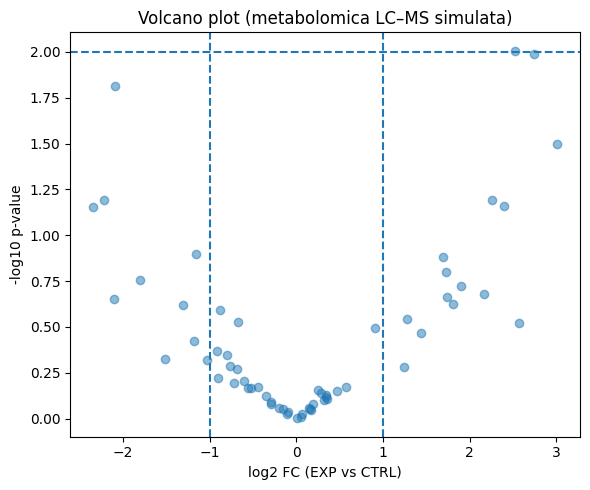

In [14]:
log2fc = res_df["log2_FC_EXP_vs_CTRL"]
neglogp = res_df["neg_log10_pval"]

plt.figure(figsize=(6,5))
plt.scatter(log2fc, neglogp, alpha=0.5)
plt.axvline(1, linestyle="--")
plt.axvline(-1, linestyle="--")
plt.axhline(2, linestyle="--")
plt.xlabel("log2 FC (EXP vs CTRL)")
plt.ylabel("-log10 p-value")
plt.title("Volcano plot (metabolomica LC–MS simulata)")
plt.tight_layout()
plt.show()

## 9. Feature candidate come biomarcatori metabolici

Applichiamo le soglie:
- |log₂FC| ≥ 1
- p-value ≤ 0.01

Queste feature potrebbero corrispondere a metaboliti legati a stress ossidativo, energia, osmoprotezione, ecc.

In [15]:
fc_thresh = 1.0
p_thresh = 0.01
hits = res_df[(res_df["log2_FC_EXP_vs_CTRL"].abs() >= fc_thresh) & (res_df["pval"] <= p_thresh)]
print(f"Numero di feature candidate: {len(hits)}")
hits.sort_values("pval").head(20)

Numero di feature candidate: 1


,FeatureID,mz,RT_min,mean_CTRL_log10,mean_EXP_log10,log2_FC_EXP_vs_CTRL,pval,neg_log10_pval
7,FT_0018,919.9852,15.569626,-2.881554,-2.123829,2.517107,0.009854,2.006388


In un dataset reale, queste feature verrebbero:
- annottate contro database metabolici (HMDB, KEGG, METLIN, ...)
- collegate a pathway (es. stress ossidativo, TCA, metabolismo degli amminoacidi).

Qui abbiamo visto in pratica la pipeline concettuale della Lecture 6:
1. Peak table LC–MS →
2. QC (TIC, distribuzioni) →
3. Normalizzazione →
4. PCA →
5. Analisi differenziale e selezione di metaboliti candidati legati all'esposizione ambientale.